In [1]:
import os
import pandas as pd
import numpy as np
import collections
import tables
import scipy.sparse as sp_sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
import seaborn as sns

import anndata
import scanpy as sc 

import harmonypy as hm

from pyInfinityFlow.InfinityFlow_Utilities import find_markers_from_anndata
from pyInfinityFlow.Plotting_Utilities import assign_rainbow_colors_to_groups

os.chdir("/media/kyle_storage/kyle_ferchen/grimes_lab_main/analysis/"\
    "2023_06_11_redo_harmony_knn_label_transfer_to_tea_seq/")

In [2]:
###############################################################################
# Helper functions
###############################################################################
print("Loading helper functions...")

def pprint(input_list):
    print("\n".join(input_list))

# CountMatrix required for `get_matrix_from_h5()`
CountMatrix = collections.namedtuple('CountMatrix', ['feature_ref', 'barcodes', 'matrix'])
def get_matrix_from_h5(filename):
    with tables.open_file(filename, 'r') as f:
        mat_group = f.get_node(f.root, 'matrix')
        barcodes = f.get_node(mat_group, 'barcodes').read()
        data = getattr(mat_group, 'data').read()
        indices = getattr(mat_group, 'indices').read()
        indptr = getattr(mat_group, 'indptr').read()
        shape = getattr(mat_group, 'shape').read()
        matrix = sp_sparse.csc_matrix((data, indices, indptr), shape=shape)
        feature_ref = {}
        feature_group = f.get_node(mat_group, 'features')
        feature_ids = getattr(feature_group, 'id').read()
        feature_names = getattr(feature_group, 'name').read()
        feature_types = getattr(feature_group, 'feature_type').read()
        feature_ref['id'] = feature_ids
        feature_ref['name'] = feature_names
        feature_ref['feature_type'] = feature_types
        tag_keys = getattr(feature_group, '_all_tag_keys').read()
        for key in tag_keys:
            feature_ref[key] = getattr(feature_group, key.decode("utf-8")).read()
            
        return CountMatrix(feature_ref, barcodes, matrix)


def check_and_rename_byte_strings(input_str):
    if type(input_str) == np.bytes_ or type(input_str) == bytes:
        return(input_str.decode("utf-8"))
    else:
        return(input_str)


def get_feature_annoation_from_10x_h5(input_h5_object):
    if type(input_h5_object) == CountMatrix:
        tmp_df = pd.DataFrame(input_h5_object.feature_ref)
        tmp_df.columns = [check_and_rename_byte_strings(item) for item in tmp_df.columns]
        for colname in tmp_df.columns:
            tmp_df[colname] = tmp_df[colname].apply(lambda x: check_and_rename_byte_strings(x))
        return(tmp_df)
    else:
        print("Error! Wrong input format! Needs to be of type <class '__main__.CountMatrix'>")
        return(None)


def pull_out_gene_expression(input_h5_object, feature_annotation):
    tmp_gene_indices = np.where(feature_annotation["feature_type"] == "Gene Expression")
    return(input_h5_object.matrix[tmp_gene_indices,:])
    
    
def make_list_items_unique(input_list):
    existing_items = {}
    output_list = []
    for tmp_item in input_list:
        if tmp_item in existing_items:
            output_list.append(tmp_item + "." + str(existing_items[tmp_item]))
            existing_items[tmp_item] += 1
        else:
            output_list.append(tmp_item)
            existing_items[tmp_item] = 1
    return(np.array(output_list))
  
  
def make_anndata_sparse_gex_from_h5_path(path_to_h5, tmp_sample_name):
    print("Working on sample {}".format(tmp_sample_name))
    print("\tLoading h5 file...")
    tmp_h5_obj = get_matrix_from_h5(path_to_h5)
    tmp_fanno = get_feature_annoation_from_10x_h5(tmp_h5_obj)
    tmp_gene_indices = np.where(tmp_fanno["feature_type"] == "Gene Expression")[0]
    tmp_adt_indices = np.where(tmp_fanno["feature_type"] == "Antibody Capture")[0]
    tmp_barcodes = np.array([check_and_rename_byte_strings(item) for item in tmp_h5_obj.barcodes])
    tmp_barcode_df = pd.DataFrame({"cell": tmp_barcodes,
        "sample": tmp_sample_name},
        index=(pd.Series(tmp_barcodes) + "." + tmp_sample_name).values)
    tmp_feature_df = pd.DataFrame(tmp_fanno.iloc[tmp_gene_indices].values,
        index=make_list_items_unique(tmp_fanno.iloc[tmp_gene_indices]["name"].values),
        columns=tmp_fanno.columns.values)
    tmp_protein_df = pd.DataFrame(tmp_h5_obj.matrix[tmp_adt_indices,:].toarray().T,
        index=tmp_barcode_df.index.values,
        columns=make_list_items_unique(tmp_fanno.iloc[tmp_adt_indices]["name"].values))
    print("\tCreating AnnData object...")
    tmp_anndata = anndata.AnnData(X=pd.DataFrame.sparse.from_spmatrix(tmp_h5_obj.matrix[tmp_gene_indices,:].T,
                index=tmp_barcode_df.index.values,
                columns=tmp_feature_df.index.values),
        obs=tmp_barcode_df,
        var=tmp_feature_df)
    tmp_anndata.obsm["protein_expression"] = tmp_protein_df
    print("Done.")
    print("")
    return(tmp_anndata)


def annotate_gene_umi_metrics(input_adata, organism):
    if organism == "Mm":
        mito_prefix = "mt-"
    elif organism == "Hs":
        mito_prefix = "MT-"
    else:
        raise Exception("<organism> not recognized... (\"Mm\" and \"Hs\" supported.)")
    mito_genes = input_adata.var.index.values[pd.Series(input_adata.var.index).str.contains(mito_prefix).values]
    n_umi_gene = np.asarray(input_adata.X.sum(axis=1)).reshape(-1)
    total_counts_mito = np.asarray(input_adata.X[:, [list(input_adata.var.index.values).index(item) for item in mito_genes]].sum(axis=1)).reshape(-1)
    tmp_df = pd.DataFrame({"n_umi_gene": n_umi_gene,
            "n_gene": np.asarray((input_adata.X > 0).sum(axis=1)).reshape(-1),
            "total_counts_mito": total_counts_mito,
            "pct_counts_mito": 100 * (total_counts_mito / (1+n_umi_gene))},
        index=input_adata.obs.index.values)
    input_adata.obs = pd.concat([input_adata.obs[input_adata.obs.columns.values[~np.isin(input_adata.obs.columns.values, tmp_df.columns.values)]],
        tmp_df], axis=1)
  
  
def annotate_hash_umi_metrics(input_adata, list_of_hash_names):
  if len(list_of_hash_names) == np.sum([item in input_adata.obsm["protein_expression"].columns.values for item in list_of_hash_names]):
    tmp_hash_df = input_adata.obsm["protein_expression"][list_of_hash_names].copy()
    frequency = (tmp_hash_df.T / tmp_hash_df.sum(axis=1)).T
    first_indices = frequency.apply(\
        lambda x: np.argsort(x.values)[-1], axis=1)
    second_indices = frequency.apply(\
        lambda x: np.argsort(x.values)[-2], axis=1)
    second_values = second_indices.reset_index().apply(\
        lambda x: frequency.loc[x["index"]].iloc[x[0]], axis=1).values
    second_values[second_values == 0] = 0.001
    first_over_second = \
        first_indices.reset_index().apply(\
            lambda x: frequency.loc[x["index"]].iloc[x[0]], axis=1).values \
        / second_values
    tmp_df = pd.DataFrame({"n_umi_hash": tmp_hash_df.sum(axis=1).values,
			    "top_hash": frequency.idxmax(axis=1),
			    "top_hash_frequency": frequency.max(axis=1),
                "first_over_second_freq": first_over_second},
			    index=input_adata.obs.index.values)
    input_adata.obs = pd.concat([input_adata.obs[input_adata.obs.columns.values[~np.isin(input_adata.obs.columns.values, tmp_df.columns.values)]],
				 tmp_df], axis=1)
  else:
    raise ValueError("Hash names not found in input_adata.obsm[\"protein_expression\"] !")
  

def separate_isotype_adt_expression(input_adata, isotype_adts):
    input_adata.obsm["isotype_protein_expression"] = input_adata.obsm["protein_expression"][isotype_adts].copy()
    input_adata.obsm["protein_expression"] = input_adata.obsm["protein_expression"].drop(labels=isotype_adts, axis=1)


def add_pct_mt_expression_to_anndata(input_adata):
    index_mt_genes = np.where([item.lower().startswith("mt-") for item in input_adata.var.index.values])[0]
    n_umi_mt_genes = np.asarray(input_adata.X[:,index_mt_genes].sum(axis=1)).reshape(-1)
    n_umi_all_genes = np.asarray(input_adata.X.sum(axis=1)).reshape(-1)
    input_adata.obs["pct_mt_genes"] = 100 * (n_umi_mt_genes / n_umi_all_genes)


def normalize_x_by_log2_cptt(input_adata):
    input_adata.X = sp_sparse.csr_matrix(np.log2((1e4 * (input_adata.X / input_adata.X.sum(axis=1))) + 1))

Loading helper functions...


In [3]:
### Read in the CITE-seq data
# Cell annotations
print("Preparing cell annotations...")
path_r7_annotations = "/media/kyle_storage/kyle_ferchen/grimes_lab_main/data/"\
    "2021_11_mouse_optimized_cite_seq/processed_files/"\
    "cell_anno_cite_r7_all_cells.csv"

cite_anno = pd.read_csv(path_r7_annotations)
cite_anno.index = cite_anno["cell"]

# 10X Cellranger count h5 file import
print("Reading in 10X genomics cellranger count data...")
path_cite_seq_data = "/media/kyle_storage/kyle_ferchen/grimes_lab_main/data/"\
    "2021_11_mouse_optimized_cite_seq/outs_10x/"

rna_cite_hsc = make_anndata_sparse_gex_from_h5_path(os.path.join(\
        path_cite_seq_data, 
        "AS_CITE_HSC", 
        "filtered_feature_bc_matrix.h5"), 
    "AS_CITE_HSC")

rna_cite_ml1 = make_anndata_sparse_gex_from_h5_path(os.path.join(\
        path_cite_seq_data, 
        "AS_CITE_Multilin1", 
        "filtered_feature_bc_matrix.h5"), 
    "AS_CITE_Multilin1")

rna_cite_ml2 = make_anndata_sparse_gex_from_h5_path(os.path.join(\
        path_cite_seq_data, 
        "AS_CITE_Multilin2", 
        "filtered_feature_bc_matrix.h5"), 
    "AS_CITE_Multilin2")


# Merge and normalize data
print("Merging RNA captures...")
rna_cite_merged = anndata.concat(\
    [rna_cite_hsc, rna_cite_ml1, rna_cite_ml2], 
    merge="same")

rna_cite_merged_raw_counts = rna_cite_merged.copy()


print("Normlizing merged RNA data by CPTT...")
normalize_x_by_log2_cptt(rna_cite_merged)


Preparing cell annotations...
Reading in 10X genomics cellranger count data...
Working on sample AS_CITE_HSC
	Loading h5 file...
	Creating AnnData object...


/tmp/ipykernel_3347526/909871885.py:90: FutureWarning: X.dtype being converted to np.float32 from int32. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tmp_anndata = anndata.AnnData(X=pd.DataFrame.sparse.from_spmatrix(tmp_h5_obj.matrix[tmp_gene_indices,:].T,


Done.

Working on sample AS_CITE_Multilin1
	Loading h5 file...
	Creating AnnData object...
Done.

Working on sample AS_CITE_Multilin2
	Loading h5 file...
	Creating AnnData object...
Done.

Merging RNA captures...
Normlizing merged RNA data by CPTT...


In [4]:
# Filter down to multilin RNA data from cite-seq and add r7 annotations
rna_cite_ml_logcptt = rna_cite_merged[\
    cite_anno.loc[\
        cite_anno["port"].isin(["AS_CITE_Multilin1", "AS_CITE_Multilin2"]), 
        "cell"].values,:].copy()

rna_cite_ml_logcptt.obs["R7"] = cite_anno.loc[\
    rna_cite_ml_logcptt.obs.index.values, "cluster"].values

# Subset to clusters with at least 25 cells
tmp_start = rna_cite_ml_logcptt.obs.shape[0]
tmp_vcounts = rna_cite_ml_logcptt.obs["R7"].value_counts()
subset_i = rna_cite_ml_logcptt.obs.loc[rna_cite_ml_logcptt.obs["R7"].isin(\
    tmp_vcounts.loc[tmp_vcounts > 25].index.values)].index.values

rna_cite_ml_logcptt = rna_cite_ml_logcptt[subset_i,:]
tmp_end = rna_cite_ml_logcptt.obs.shape[0]

print("Filtered {} cells down to {}...".format(tmp_start, tmp_end))


Filtered 12052 cells down to 11917...


In [5]:
# Assign colors to R7 groups
tmp_colors_r7 = assign_rainbow_colors_to_groups(cite_anno["cluster"].values)
tmp_colors_r7

{'B-cell progenitor': '#8000ff',
 'BMCP': '#7c06ff',
 'Baso': '#7610ff',
 'Bcl11b+_preETP_Cd3d': '#7019ff',
 'Bcl11b+_preETP_Tdrd5': '#6a22fe',
 'CD127-BMCP': '#642cfe',
 'CD127-MP': '#5e35fe',
 'CHILP': '#583efd',
 'CLP1-Hist1h1c': '#5247fc',
 'CLP1-Rrm2': '#4c50fc',
 'CLP2': '#4659fb',
 'DN4-DP-trans_Hist1h3c': '#4062fa',
 'EILP': '#3c68f9',
 'ERP1': '#3670f8',
 'ERP2': '#3079f7',
 'ERP2-Arhgdig': '#2981f6',
 'ERP4-Alas2': '#2489f5',
 'ERP4-Bcl2l15': '#1e91f3',
 'ETP-A-0': '#1898f2',
 'ETP-CC-4': '#11a0f1',
 'ETP-IFN-10-Ifit3': '#0ca7ef',
 'Ebf1+ proB_Hmga2': '#06aeed',
 'Ebf1+ proB_Mxd3': '#00b5eb',
 'Ebf1+ proB_Smtnl2': '#04b9ea',
 'Ebf1+ proB_Uhrf1': '#0ac0e8',
 'Eosinophils': '#10c6e6',
 'HSC-Mac_Fcna': '#17cbe4',
 'HSCP-ERP1': '#1dd1e2',
 'HSCP-HPC_Cenpf': '#22d6e0',
 'HSCP-HPC_Hist1h2af': '#28dbde',
 'HSCP-HPC_Tk1': '#2fe0db',
 'HSCP-MKP': '#34e4d9',
 'IG2-MP': '#3ae8d6',
 'IG2-proNeu1': '#40ecd4',
 'ILC1-ILC3-NKP': '#44eed2',
 'ILC2': '#4af2cf',
 'ILCP-Clip4': '#50f4cc',
 'ILC

Finding markers for Infinity Flow object...
Plotting markers...


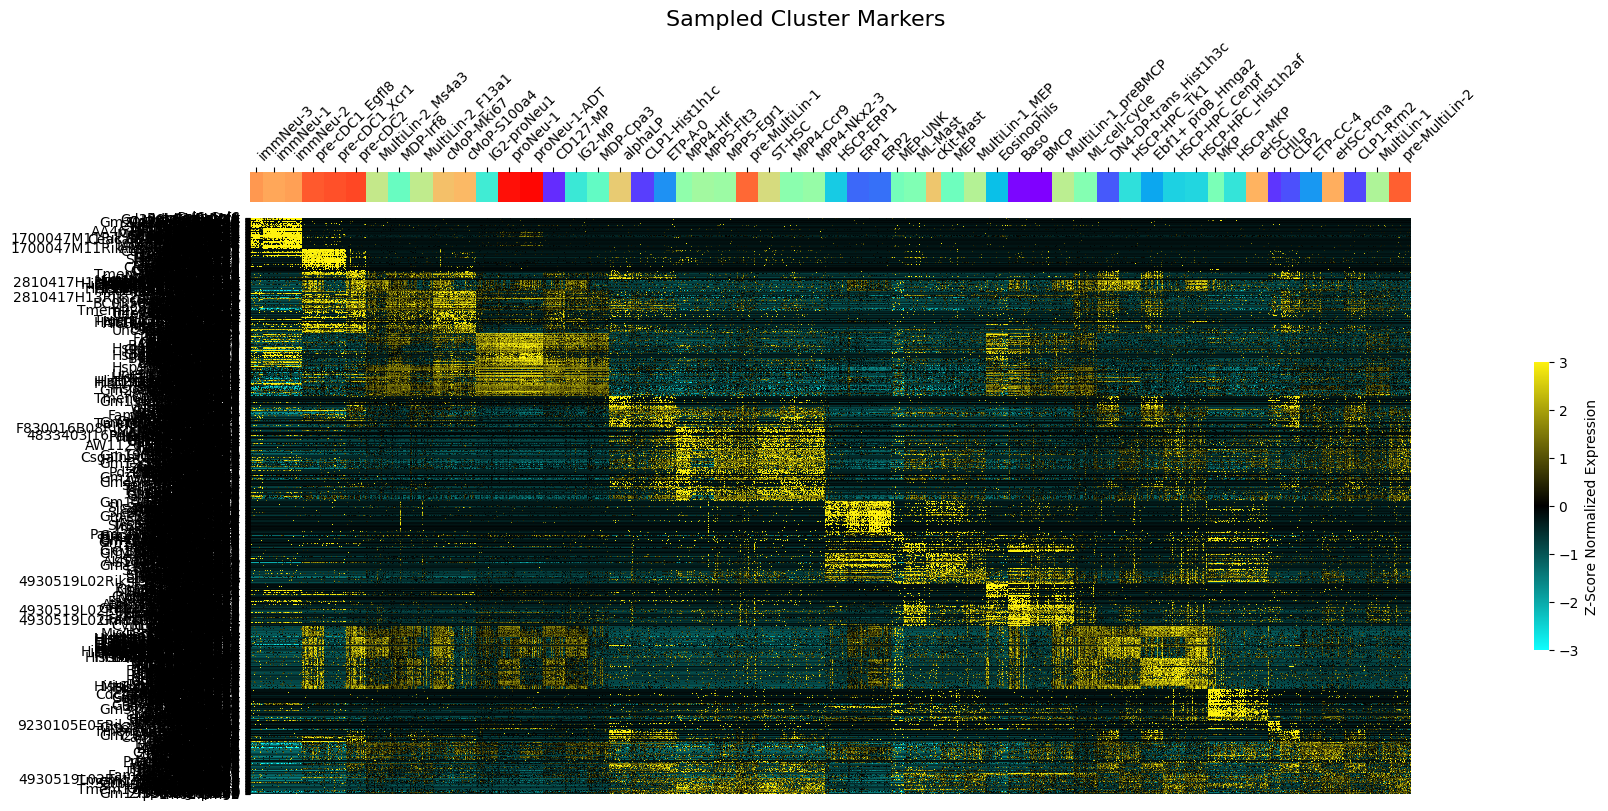

In [6]:
### Markerfinder CITE-seq for multilin captures
## Gene selection
tmp_cells_per_gene = pd.Series((\
    rna_cite_ml_logcptt.X > 0).toarray().sum(axis=0).reshape(-1),
    index=rna_cite_ml_logcptt.var.index.values)

# Force genes to be above 0 log2 cptt in at least 25 cells
tmp_cells_per_gene = tmp_cells_per_gene[tmp_cells_per_gene > 25]

# Exclude mitochondrial genes
tmp_cells_per_gene = tmp_cells_per_gene.loc[\
    ~tmp_cells_per_gene.index.str.startswith("mt-")]

tmp_input_adata = rna_cite_ml_logcptt[:,tmp_cells_per_gene.index.values].copy()
tmp_input_adata.X = tmp_input_adata.X.toarray()

cite_ml_marker_genes = find_markers_from_anndata(\
    tmp_input_adata, 
    output_dir="output/markerfinder/cite_multilin_captures/", 
    groups_to_colors=tmp_colors_r7, 
    top_n_markers=25, 
    cluster_key='R7', 
    verbosity=3)


In [7]:
# Get the top 25 marker genes defining each cluster
top_markers = []
n_markers = 25
for tmp_cluster in cite_ml_marker_genes[0]["top_cluster"].unique():
    seg_markers = cite_ml_marker_genes[0].loc[\
        cite_ml_marker_genes[0]["top_cluster"] == tmp_cluster].copy()
    seg_markers = seg_markers.sort_values(by="pearson_r", ascending=False)
    seg_markers.index = [i.split(":")[0] for i in seg_markers["marker"].values]
    if seg_markers.shape[0] > n_markers:
        top_markers.append(seg_markers.head(n_markers))
    else:
        top_markers.append(seg_markers)

top_markers = pd.concat(top_markers)
top_markers


marker     top_cluster  pearson_r       p_value
Ccl6           Ccl6:Ccl6        immNeu-3   0.658049  0.000000e+00
Il1f9        Il1f9:Il1f9        immNeu-3   0.621272  0.000000e+00
Cd300ld  Cd300ld:Cd300ld        immNeu-3   0.533008  0.000000e+00
Lilrb4a  Lilrb4a:Lilrb4a        immNeu-3   0.522698  0.000000e+00
Ccr1           Ccr1:Ccr1        immNeu-3   0.519751  0.000000e+00
...                  ...             ...        ...           ...
Tmem57     Tmem57:Tmem57  pre-MultiLin-2   0.050858  2.777002e-08
Parp3        Parp3:Parp3  pre-MultiLin-2   0.050631  3.200367e-08
Rnf11        Rnf11:Rnf11  pre-MultiLin-2   0.049988  4.765976e-08
Ing5           Ing5:Ing5  pre-MultiLin-2   0.047542  2.077342e-07
Scrn2        Scrn2:Scrn2  pre-MultiLin-2   0.046978  2.888148e-07

[1375 rows x 4 columns]

In [8]:
### Read in the TEA-seq data
# 10X Cellranger arc h5 file import
print("Reading in 10X genomics cellranger arc data...")
path_tea_seq_data = "/media/kyle_storage/kyle_ferchen/grimes_lab_main/data/"\
    "2021_12_mouse_tea_seq/cellRanger-ARC/"

rna_tea_h1 = make_anndata_sparse_gex_from_h5_path(os.path.join(\
        path_tea_seq_data, 
        "AS_TEAr_H1", 
        "filtered_feature_bc_matrix.h5"), 
    "AS_TEAr_H1")

rna_tea_h2 = make_anndata_sparse_gex_from_h5_path(os.path.join(\
        path_tea_seq_data, 
        "AS_TEAr_H2", 
        "filtered_feature_bc_matrix.h5"), 
    "AS_TEAr_H2")

rna_tea_m1 = make_anndata_sparse_gex_from_h5_path(os.path.join(\
        path_tea_seq_data, 
        "AS_TEAr_ML1", 
        "filtered_feature_bc_matrix.h5"), 
    "AS_TEAr_M1")

rna_tea_m2 = make_anndata_sparse_gex_from_h5_path(os.path.join(\
        path_tea_seq_data, 
        "AS_TEAr_ML2", 
        "filtered_feature_bc_matrix.h5"), 
    "AS_TEAr_M2")


# Merge and normalize data
print("Merging TEA captures...")
rna_tea_merged = anndata.concat(\
    [rna_tea_h1, rna_tea_h2, rna_tea_m1, rna_tea_m2], 
    merge="same")

rna_tea_merged_raw_counts = rna_tea_merged.copy()


print("Normlizing merged TEA data by CPTT...")
normalize_x_by_log2_cptt(rna_tea_merged)


Reading in 10X genomics cellranger arc data...
Working on sample AS_TEAr_H1
	Loading h5 file...
	Creating AnnData object...


/tmp/ipykernel_3347526/909871885.py:90: FutureWarning: X.dtype being converted to np.float32 from int32. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tmp_anndata = anndata.AnnData(X=pd.DataFrame.sparse.from_spmatrix(tmp_h5_obj.matrix[tmp_gene_indices,:].T,


Done.

Working on sample AS_TEAr_H2
	Loading h5 file...
	Creating AnnData object...
Done.

Working on sample AS_TEAr_M1
	Loading h5 file...
	Creating AnnData object...
Done.

Working on sample AS_TEAr_M2
	Loading h5 file...
	Creating AnnData object...
Done.

Merging TEA captures...
Normlizing merged TEA data by CPTT...


In [9]:
### Filter TEA RNA data down to multilin to prepare for integration
rna_tea_ml_logcptt = rna_tea_merged[\
    rna_tea_merged.obs.loc[rna_tea_merged.obs["sample"].isin(\
        ["AS_TEAr_M1", "AS_TEAr_M2"])].index.values,
    :].copy()

In [10]:
# Get shared marker genes between CITE-seq and TEA-seq captures
shared_markers_ml = np.intersect1d(\
    top_markers.index.values,
    rna_tea_ml_logcptt.var.index.values)

len(shared_markers_ml)

1331

In [11]:
# How many of the marker genes are expressed in the TEA cells
tea_markers_n_genes_per_cell = pd.Series(\
    (rna_tea_ml_logcptt[:,shared_markers_ml].X.toarray() > 0).sum(axis=1),
    index=rna_tea_ml_logcptt.obs.index.values)

tea_markers_n_genes_per_cell.sort_values()

GGTTTCCTCATGTTTC-1.AS_TEAr_M1     18
TGTTGCACAGCATTAT-1.AS_TEAr_M1     20
CGTAACCCAACAGCCT-1.AS_TEAr_M1     21
CCGCTTAGTCCTCCAA-1.AS_TEAr_M2     22
ATTAGCTCAGCCAGTT-1.AS_TEAr_M1     22
                                ... 
CGCTCCATCCGGTTAG-1.AS_TEAr_M2    373
GTCCTAGAGTGAGCGG-1.AS_TEAr_M2    378
AGTTGTCAGGAGCAAC-1.AS_TEAr_M2    390
AGCGCCTAGCTTAGTA-1.AS_TEAr_M2    392
TCCAGGATCCATAATG-1.AS_TEAr_M1    601
Length: 26917, dtype: int64

In [12]:
# How many of the marker genes are expressed in the CITE cells
cite_markers_n_genes_per_cell = pd.Series(\
    (rna_cite_ml_logcptt[:,shared_markers_ml].X.toarray() > 0).sum(axis=1),
    index=rna_cite_ml_logcptt.obs.index.values)

cite_markers_n_genes_per_cell.sort_values()

ATGGATCGTTTCCCAC-1.AS_CITE_Multilin2     63
CCGATCTAGCCACAAG-1.AS_CITE_Multilin2     66
AAGAACATCGCACGAC-1.AS_CITE_Multilin1     67
CCACGAGCAAGGCCTC-1.AS_CITE_Multilin2     67
AGCTTCCAGCTCATAC-1.AS_CITE_Multilin2     69
                                       ... 
ACCTGAAAGATCACCT-1.AS_CITE_Multilin1    587
TCCACCATCATACAGC-1.AS_CITE_Multilin1    603
CTGTACCCAGACGATG-1.AS_CITE_Multilin1    604
CCTTCAGGTGCATGAG-1.AS_CITE_Multilin2    610
ACTTTCAGTTTACACG-1.AS_CITE_Multilin1    612
Length: 11917, dtype: int64

In [13]:
# Merge multilin cite and tea rna adata objects on shared CITE derived markers
merged_ml = anndata.concat([\
        rna_cite_ml_logcptt[:,shared_markers_ml], 
        rna_tea_ml_logcptt[:,shared_markers_ml]], 
    merge="same")

merged_ml.obs["batch"] = "Unknown"
merged_ml.obs.loc[rna_cite_ml_logcptt.obs.index.values, "batch"] = "CITE"
merged_ml.obs.loc[rna_tea_ml_logcptt.obs.index.values, "batch"] = "TEA"

merged_ml

AnnData object with n_obs × n_vars = 38834 × 1331
    obs: 'cell', 'sample', 'batch'
    var: 'name', 'feature_type', 'genome'
    obsm: 'protein_expression'

2023-07-12 00:28:43,139 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-07-12 00:28:56,921 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-07-12 00:28:57,167 - harmonypy - INFO - Iteration 1 of 10
2023-07-12 00:29:15,348 - harmonypy - INFO - Iteration 2 of 10
2023-07-12 00:29:33,339 - harmonypy - INFO - Iteration 3 of 10
2023-07-12 00:29:53,056 - harmonypy - INFO - Iteration 4 of 10
2023-07-12 00:30:12,572 - harmonypy - INFO - Iteration 5 of 10
2023-07-12 00:30:31,520 - harmonypy - INFO - Iteration 6 of 10
2023-07-12 00:30:48,923 - harmonypy - INFO - Iteration 7 of 10
2023-07-12 00:31:05,085 - harmonypy - INFO - Iteration 8 of 10
2023-07-12 00:31:22,094 - harmonypy - INFO - Iteration 9 of 10
2023-07-12 00:31:40,079 - harmonypy - INFO - Iteration 10 of 10
2023-07-12 00:31:56,275 - harmonypy - INFO - Converged after 10 iterations
/home/kyle/anaconda3/envs/pyInfinityFlow/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: 

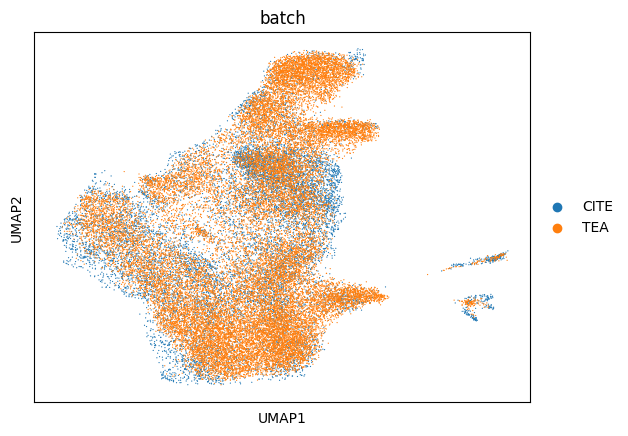

In [14]:
# Perform harmony for multilin merged CITE-seq and TEA-seq
sc.tl.pca(merged_ml,n_comps=50)
ho = hm.run_harmony(merged_ml.obsm['X_pca'][:,1:],merged_ml.obs,['batch'])
merged_ml.obsm['X_pca_harmony'] = ho.Z_corr.T
sc.pp.neighbors(merged_ml,use_rep='X_pca_harmony')
sc.tl.umap(merged_ml)
sc.pl.umap(merged_ml, color="batch")

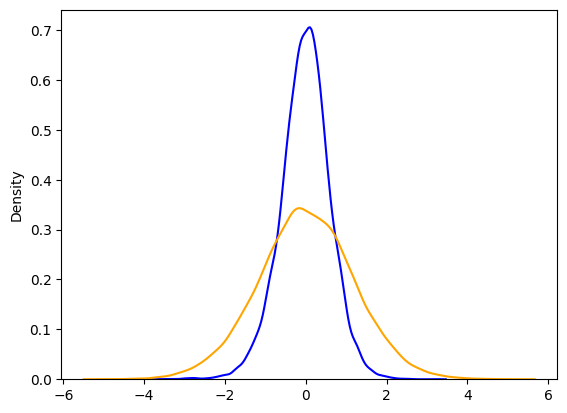

In [15]:
# Make KDE plots to view variance between CITE and TEA seq batches
for i in range(merged_ml.obsm['X_pca'].shape[1]):
    plt.close("all")
    sns.kdeplot(\
        merged_ml.obsm['X_pca'][(merged_ml.obs["batch"] == "CITE").values,i],
        color="blue")
    sns.kdeplot(\
        merged_ml.obsm['X_pca'][(merged_ml.obs["batch"] == "TEA").values,i],
        color="orange")
    plt.savefig("output/qc_pca_vs_batch/ml/pca_kde_by_batch_cite_blue_tea_orange_pc_{}.png".format(i+1))

In [16]:
### Perform KNN for MultiLin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

adata_train = merged_ml[merged_ml.obs["batch"] == "CITE",:].copy()
adata_test = merged_ml[merged_ml.obs["batch"] == "TEA",:].copy()

train_labels = cite_anno.loc[adata_train.obs.index.values, "cluster"].values
le_ml = LabelEncoder().fit(train_labels)
train_labels_encoded = le_ml.transform(train_labels)

knn_model_ml = KNeighborsClassifier(n_neighbors=15,weights='distance')
knn_model_ml.fit(adata_train.obsm['X_pca_harmony'],train_labels_encoded)
tmp_preds = le_ml.inverse_transform(knn_model_ml.predict(\
    adata_test.obsm['X_pca_harmony']))

tea_r7_ml_preds = pd.Series(\
    tmp_preds,
    index = adata_test.obs.index.values)

tea_r7_ml_preds

AAACAGCCAACTGGCT-1.AS_TEAr_M1       ML-cell-cycle
AAACAGCCACAATGTT-1.AS_TEAr_M1           MPP5-Egr1
AAACAGCCACGTAAGG-1.AS_TEAr_M1            proNeu-1
AAACAGCCAGGACCAA-1.AS_TEAr_M1            MDP-Cpa3
AAACAGCCAGTTTGGC-1.AS_TEAr_M1         IG2-proNeu1
                                       ...       
TTTGTTGGTATTCGTC-1.AS_TEAr_M2      pre-MultiLin-1
TTTGTTGGTCTATCGT-1.AS_TEAr_M2              IG2-MP
TTTGTTGGTGACCTGG-1.AS_TEAr_M2            immNeu-3
TTTGTTGGTGTCACGG-1.AS_TEAr_M2         IG2-proNeu1
TTTGTTGGTTGCAATG-1.AS_TEAr_M2    MultiLin-2_F13a1
Length: 26917, dtype: object

/home/kyle/anaconda3/envs/pyInfinityFlow/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


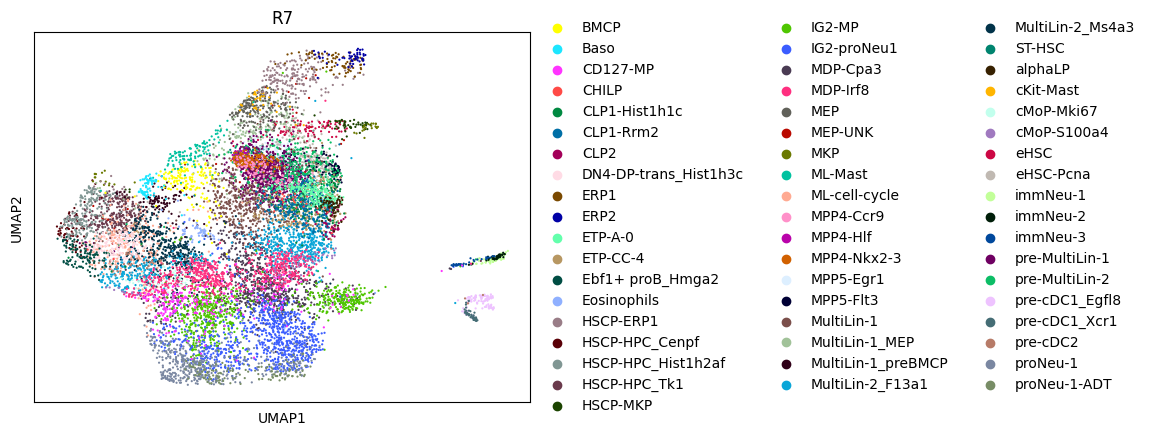

In [17]:
adata_train.obs["R7"] = cite_anno.loc[adata_train.obs.index.values, "cluster"].values

sc.pl.umap(adata_train, color="R7", legend_loc="right margin")

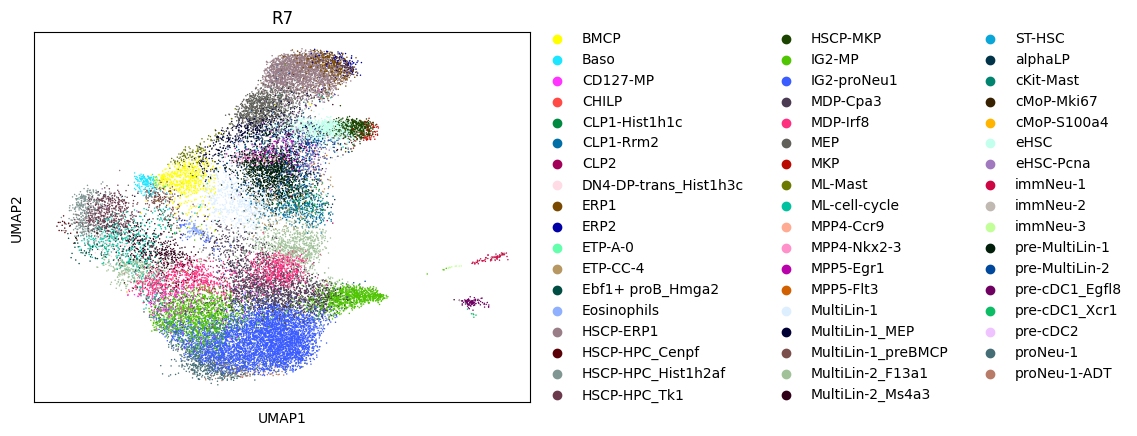

In [18]:
adata_test.obs["R7"] = tea_r7_ml_preds.loc[adata_test.obs.index.values]

sc.pl.umap(adata_test, color="R7", legend_loc="right margin")

# Replicate everthing for HSCP captures!!!

In [19]:
# Filter down to hscp RNA data from cite-seq and add r7 annotations
rna_cite_hscp_logcptt = rna_cite_merged[\
    cite_anno.loc[\
        cite_anno["port"].isin(["AS_CITE_HSC"]), 
        "cell"].values,:].copy()

rna_cite_hscp_logcptt.obs["R7"] = cite_anno.loc[\
    rna_cite_hscp_logcptt.obs.index.values, "cluster"].values

# Subset to clusters with at least 25 cells
tmp_start = rna_cite_hscp_logcptt.obs.shape[0]
tmp_vcounts = rna_cite_hscp_logcptt.obs["R7"].value_counts()
subset_i = rna_cite_hscp_logcptt.obs.loc[rna_cite_hscp_logcptt.obs["R7"].isin(\
    tmp_vcounts.loc[tmp_vcounts > 25].index.values)].index.values

rna_cite_hscp_logcptt = rna_cite_hscp_logcptt[subset_i,:]
tmp_end = rna_cite_hscp_logcptt.obs.shape[0]

print("Filtered {} cells down to {}...".format(tmp_start, tmp_end))

Filtered 8034 cells down to 7807...


Finding markers for Infinity Flow object...
Plotting markers...


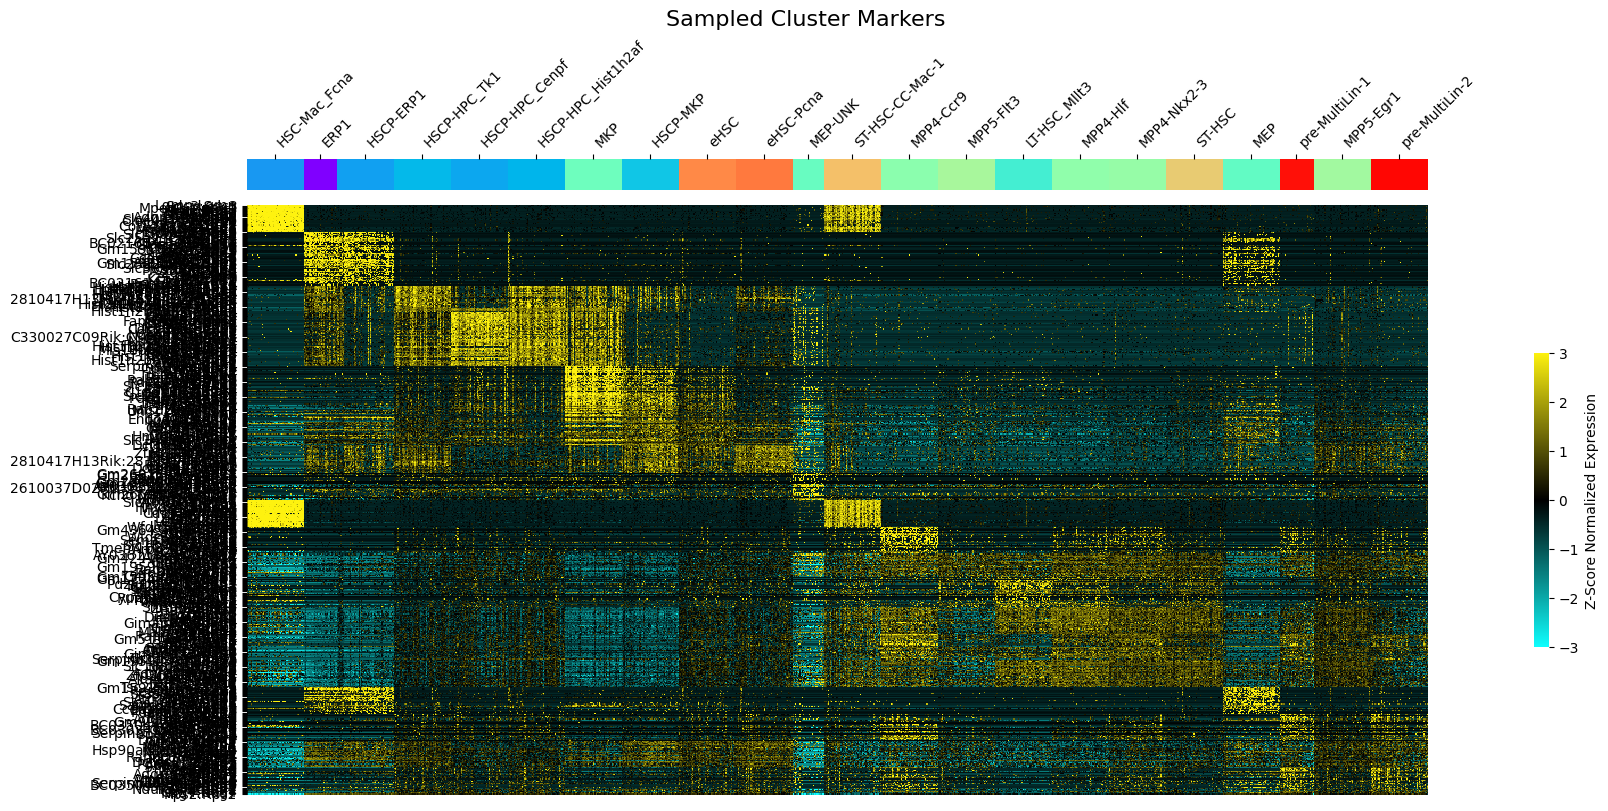

In [20]:
### Markerfinder CITE-seq for HSCP captures
## Gene selection
tmp_cells_per_gene_hscp = pd.Series((\
    rna_cite_hscp_logcptt.X > 0).toarray().sum(axis=0).reshape(-1),
    index=rna_cite_hscp_logcptt.var.index.values)

# Force genes to be above 0 log2 cptt in at least 25 cells
tmp_cells_per_gene_hscp = tmp_cells_per_gene_hscp[tmp_cells_per_gene_hscp > 25]

# Exclude mitochondrial genes
tmp_cells_per_gene_hscp = tmp_cells_per_gene_hscp.loc[\
    ~tmp_cells_per_gene_hscp.index.str.startswith("mt-")]

tmp_input_adata = rna_cite_hscp_logcptt[:,tmp_cells_per_gene_hscp.index.values].copy()
tmp_input_adata.X = tmp_input_adata.X.toarray()

cite_hscp_marker_genes = find_markers_from_anndata(\
    tmp_input_adata, 
    output_dir="output/markerfinder/cite_hscp_captures/", 
    groups_to_colors=tmp_colors_r7, 
    top_n_markers=25, 
    cluster_key='R7', 
    verbosity=3)

In [21]:
# Get the top 25 marker genes defining each cluster
top_markers_hscp = []
n_markers = 25
for tmp_cluster in cite_hscp_marker_genes[0]["top_cluster"].unique():
    seg_markers = cite_hscp_marker_genes[0].loc[\
        cite_hscp_marker_genes[0]["top_cluster"] == tmp_cluster].copy()
    seg_markers = seg_markers.sort_values(by="pearson_r", ascending=False)
    seg_markers.index = [i.split(":")[0] for i in seg_markers["marker"].values]
    if seg_markers.shape[0] > n_markers:
        top_markers_hscp.append(seg_markers.head(n_markers))
    else:
        top_markers_hscp.append(seg_markers)

top_markers_hscp = pd.concat(top_markers_hscp)
top_markers_hscp

marker     top_cluster  pearson_r   p_value
Lgmn                    Lgmn:Lgmn    HSC-Mac_Fcna   0.847415  0.000000
Sdc3                    Sdc3:Sdc3    HSC-Mac_Fcna   0.835087  0.000000
Mpeg1                 Mpeg1:Mpeg1    HSC-Mac_Fcna   0.830121  0.000000
Ccr3                    Ccr3:Ccr3    HSC-Mac_Fcna   0.828962  0.000000
Mrc1                    Mrc1:Mrc1    HSC-Mac_Fcna   0.826593  0.000000
...                           ...             ...        ...       ...
Prr18                 Prr18:Prr18  pre-MultiLin-2   0.036649  0.001200
Pitpnm2os2  Pitpnm2os2:Pitpnm2os2  pre-MultiLin-2   0.035975  0.001477
Fig4                    Fig4:Fig4  pre-MultiLin-2   0.035016  0.001972
Tubgcp5           Tubgcp5:Tubgcp5  pre-MultiLin-2   0.033985  0.002671
Bloc1s6os     Bloc1s6os:Bloc1s6os  pre-MultiLin-2   0.033868  0.002764

[550 rows x 4 columns]

In [22]:
### Filter TEA RNA data down to HSCP to prepare for integration
rna_tea_hscp_logcptt = rna_tea_merged[\
    rna_tea_merged.obs.loc[rna_tea_merged.obs["sample"].isin(\
        ["AS_TEAr_H1", "AS_TEAr_H2"])].index.values,
    :].copy()

In [23]:
# Get shared marker genes between CITE-seq and TEA-seq captures
shared_markers_hscp = np.intersect1d(\
    top_markers_hscp.index.values,
    rna_tea_hscp_logcptt.var.index.values)

len(shared_markers_hscp)

526

In [24]:
# How many of the marker genes are expressed in the TEA cells
tea_markers_n_genes_per_cell_hscp = pd.Series(\
    (rna_tea_hscp_logcptt[:,shared_markers_hscp].X.toarray() > 0).sum(axis=1),
    index=rna_tea_hscp_logcptt.obs.index.values)

tea_markers_n_genes_per_cell_hscp.sort_values()

GTACTAATCCAGGAAA-1.AS_TEAr_H2     13
TTAACTGAGGCGGATG-1.AS_TEAr_H2     13
TGTGGCCAGTGAGCAA-1.AS_TEAr_H1     19
TCCTTTACAACTAGAA-1.AS_TEAr_H1     19
GAGTGATCAGGCCAAA-1.AS_TEAr_H2     21
                                ... 
GGTGCTGGTGAGACTC-1.AS_TEAr_H2    272
GCGCGATTCAATCTCT-1.AS_TEAr_H2    281
GCCTTACTCCCTCTAA-1.AS_TEAr_H1    282
CGCAATCCACTGGCTG-1.AS_TEAr_H1    290
GTTTGCTGTTACCTGT-1.AS_TEAr_H1    343
Length: 19187, dtype: int64

In [25]:
# How many of the marker genes are expressed in the CITE cells
cite_markers_n_genes_per_cell_hscp = pd.Series(\
    (rna_cite_hscp_logcptt[:,shared_markers_hscp].X.toarray() > 0).sum(axis=1),
    index=rna_cite_hscp_logcptt.obs.index.values)

cite_markers_n_genes_per_cell_hscp.sort_values()

TTCACCGCAATTTCTC-1.AS_CITE_HSC     52
GCGATCGAGCCGGAAT-1.AS_CITE_HSC     53
GTAATGCCATTAGGCT-1.AS_CITE_HSC     54
GTGAGCCGTAGTGATA-1.AS_CITE_HSC     55
GAACGTTCAAACACCT-1.AS_CITE_HSC     56
                                 ... 
AACCTGACAATACGCT-1.AS_CITE_HSC    340
TCACACCTCGAGCACC-1.AS_CITE_HSC    340
GTTCCGTTCATCACAG-1.AS_CITE_HSC    341
TAACGACCAGACCAAG-1.AS_CITE_HSC    343
CCCAACTTCAATCGGT-1.AS_CITE_HSC    351
Length: 7807, dtype: int64

In [26]:
# Merge multilin cite and tea rna adata objects on shared CITE derived markers
merged_hscp = anndata.concat([\
        rna_cite_hscp_logcptt[:,shared_markers_hscp], 
        rna_tea_hscp_logcptt[:,shared_markers_hscp]], 
    merge="same")

merged_hscp.obs["batch"] = "Unknown"
merged_hscp.obs.loc[rna_cite_hscp_logcptt.obs.index.values, "batch"] = "CITE"
merged_hscp.obs.loc[rna_tea_hscp_logcptt.obs.index.values, "batch"] = "TEA"

merged_hscp

AnnData object with n_obs × n_vars = 26994 × 526
    obs: 'cell', 'sample', 'batch'
    var: 'name', 'feature_type', 'genome'
    obsm: 'protein_expression'

2023-07-12 00:35:23,946 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-07-12 00:35:36,626 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-07-12 00:35:36,811 - harmonypy - INFO - Iteration 1 of 10
2023-07-12 00:35:47,597 - harmonypy - INFO - Iteration 2 of 10
2023-07-12 00:35:58,506 - harmonypy - INFO - Iteration 3 of 10
2023-07-12 00:36:08,930 - harmonypy - INFO - Iteration 4 of 10
2023-07-12 00:36:19,547 - harmonypy - INFO - Iteration 5 of 10
2023-07-12 00:36:25,122 - harmonypy - INFO - Iteration 6 of 10
2023-07-12 00:36:30,556 - harmonypy - INFO - Iteration 7 of 10
2023-07-12 00:36:35,148 - harmonypy - INFO - Iteration 8 of 10
2023-07-12 00:36:39,444 - harmonypy - INFO - Iteration 9 of 10
2023-07-12 00:36:43,487 - harmonypy - INFO - Iteration 10 of 10
2023-07-12 00:36:47,386 - harmonypy - INFO - Converged after 10 iterations
/home/kyle/anaconda3/envs/pyInfinityFlow/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: 

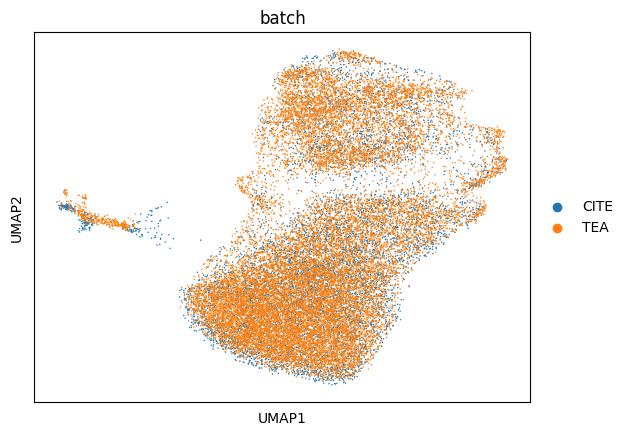

In [27]:
# Perform harmony for multilin merged CITE-seq and TEA-seq
sc.tl.pca(merged_hscp,n_comps=50)
ho_hscp = hm.run_harmony(merged_hscp.obsm['X_pca'][:,1:],merged_hscp.obs,['batch'])
merged_hscp.obsm['X_pca_harmony'] = ho_hscp.Z_corr.T
sc.pp.neighbors(merged_hscp,use_rep='X_pca_harmony')
sc.tl.umap(merged_hscp)
sc.pl.umap(merged_hscp, color="batch")

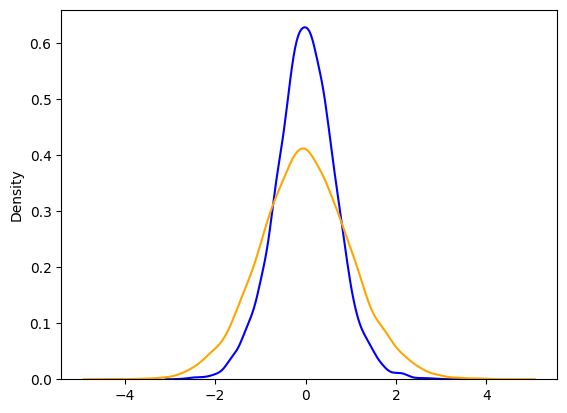

In [28]:
# Make KDE plots to view variance between CITE and TEA seq batches
for i in range(merged_hscp.obsm['X_pca'].shape[1]):
    plt.close("all")
    sns.kdeplot(\
        merged_hscp.obsm['X_pca'][(merged_hscp.obs["batch"] == "CITE").values,i],
        color="blue")
    sns.kdeplot(\
        merged_hscp.obsm['X_pca'][(merged_hscp.obs["batch"] == "TEA").values,i],
        color="orange")
    plt.savefig("output/qc_pca_vs_batch/hscp/pca_kde_by_batch_cite_blue_tea_orange_pc_{}.png".format(i+1))



In [29]:
### Perform KNN for MultiLin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

adata_train_hscp = merged_hscp[merged_hscp.obs["batch"] == "CITE",:].copy()
adata_test_hscp = merged_hscp[merged_hscp.obs["batch"] == "TEA",:].copy()

train_labels_hscp = cite_anno.loc[adata_train_hscp.obs.index.values, "cluster"].values
le_hscp = LabelEncoder().fit(train_labels_hscp)
train_labels_hscp_encoded = le_hscp.transform(train_labels_hscp)

print("Starting KNN model...")
knn_model_hscp = KNeighborsClassifier(n_neighbors=15,weights='distance')
knn_model_hscp.fit(adata_train_hscp.obsm['X_pca_harmony'],train_labels_hscp_encoded)
tmp_preds = le_hscp.inverse_transform(knn_model_hscp.predict(\
    adata_test_hscp.obsm['X_pca_harmony']))

tea_r7_hscp_preds = pd.Series(\
    tmp_preds,
    index = adata_test_hscp.obs.index.values)

tea_r7_hscp_preds

Starting KNN model...


AAACAGCCAAACCCTA-1.AS_TEAr_H1            ST-HSC
AAACAGCCAATTTAGC-1.AS_TEAr_H1      HSCP-HPC_Tk1
AAACAGCCACCAGCAT-1.AS_TEAr_H1      LT-HSC_Mllt3
AAACAGCCAGCTCAAC-1.AS_TEAr_H1    HSCP-HPC_Cenpf
AAACAGCCAGGAACTG-1.AS_TEAr_H1         eHSC-Pcna
                                      ...      
TTTGTGTTCTCCTCAA-1.AS_TEAr_H2            ST-HSC
TTTGTGTTCTTACTCG-1.AS_TEAr_H2      HSCP-HPC_Tk1
TTTGTTGGTCAGTAAT-1.AS_TEAr_H2         MPP5-Egr1
TTTGTTGGTGCACGCA-1.AS_TEAr_H2            ST-HSC
TTTGTTGGTTCACCAT-1.AS_TEAr_H2          MPP4-Hlf
Length: 19187, dtype: object

/home/kyle/anaconda3/envs/pyInfinityFlow/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


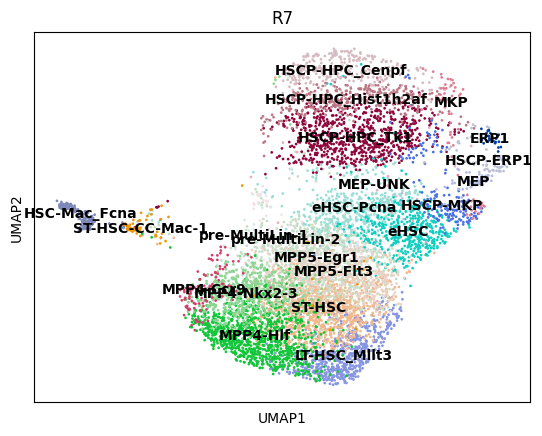

In [30]:
adata_train_hscp.obs["R7"] = cite_anno.loc[adata_train_hscp.obs.index.values, "cluster"].values

sc.pl.umap(adata_train_hscp, color="R7", legend_loc="on data")

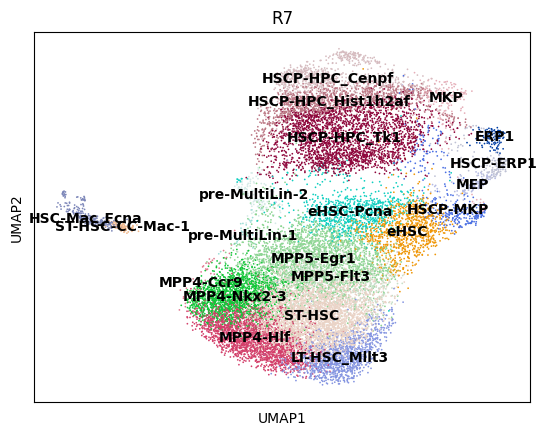

In [31]:
adata_test_hscp.obs["R7"] = tea_r7_hscp_preds.loc[adata_test_hscp.obs.index.values]

sc.pl.umap(adata_test_hscp, color="R7", legend_loc="on data")

# Export the final transferred labels!!!

In [32]:
tea_final_anno = pd.DataFrame({\
    "cell": np.concatenate([\
        tea_r7_ml_preds.index.values, 
        tea_r7_hscp_preds.index.values]),
    "R7": np.concatenate([\
        tea_r7_ml_preds.values, 
        tea_r7_hscp_preds.values])})

tea_final_anno

cell             R7
0      AAACAGCCAACTGGCT-1.AS_TEAr_M1  ML-cell-cycle
1      AAACAGCCACAATGTT-1.AS_TEAr_M1      MPP5-Egr1
2      AAACAGCCACGTAAGG-1.AS_TEAr_M1       proNeu-1
3      AAACAGCCAGGACCAA-1.AS_TEAr_M1       MDP-Cpa3
4      AAACAGCCAGTTTGGC-1.AS_TEAr_M1    IG2-proNeu1
...                              ...            ...
46099  TTTGTGTTCTCCTCAA-1.AS_TEAr_H2         ST-HSC
46100  TTTGTGTTCTTACTCG-1.AS_TEAr_H2   HSCP-HPC_Tk1
46101  TTTGTTGGTCAGTAAT-1.AS_TEAr_H2      MPP5-Egr1
46102  TTTGTTGGTGCACGCA-1.AS_TEAr_H2         ST-HSC
46103  TTTGTTGGTTCACCAT-1.AS_TEAr_H2       MPP4-Hlf

[46104 rows x 2 columns]

In [33]:
# tea_final_anno.to_csv(\
#     "output/tea_seq_r7_label_transfer_from_cite_seq_06_2023.csv",
#     header=True, index=False)

In [35]:
# Save integrated objects as h5ad files
merged_ml.write("output/merged_ml.h5ad")
merged_hscp.write("output/merged_hscp.h5ad")

In [49]:
og_tea_final_anno = pd.read_csv("output/tea_seq_r7_label_transfer_from_cite_seq_06_2023.csv")
og_tea_final_anno.index = og_tea_final_anno["cell"].values
og_tea_final_anno.head()

cell             R7
AAACAGCCAACTGGCT-1.AS_TEAr_M1  AAACAGCCAACTGGCT-1.AS_TEAr_M1  ML-cell-cycle
AAACAGCCACAATGTT-1.AS_TEAr_M1  AAACAGCCACAATGTT-1.AS_TEAr_M1      MPP5-Egr1
AAACAGCCACGTAAGG-1.AS_TEAr_M1  AAACAGCCACGTAAGG-1.AS_TEAr_M1       proNeu-1
AAACAGCCAGGACCAA-1.AS_TEAr_M1  AAACAGCCAGGACCAA-1.AS_TEAr_M1       MDP-Cpa3
AAACAGCCAGTTTGGC-1.AS_TEAr_M1  AAACAGCCAGTTTGGC-1.AS_TEAr_M1    IG2-proNeu1

In [58]:
x = og_tea_final_anno.copy()
x["port"] = [i.split(".")[-1] for i in x["cell"].values]

merged_ml_umap_coors = pd.DataFrame(\
    merged_ml.obsm['X_umap'],
    index = merged_ml.obs.index.values,
    columns = ["umap-x", "umap-y"])

tea_anno_with_umap_ml = x.loc[x["port"].isin(\
    ["AS_TEAr_M1", "AS_TEAr_M2"])].copy()


tea_anno_with_umap_ml[["umap-x", "umap-y"]] = merged_ml_umap_coors.loc[\
    tea_anno_with_umap_ml["cell"].values,
    ["umap-x", "umap-y"]].values

tea_anno_with_umap_ml = tea_anno_with_umap_ml[["cell", "R7", "umap-x", "umap-y"]]
tea_anno_with_umap_ml.to_csv(\
    "output/tea_seq_r7_label_transfer_from_cite_seq_06_2023_multilin_with_umap.csv")


In [56]:
x = og_tea_final_anno.copy()
x["port"] = [i.split(".")[-1] for i in x["cell"].values]

merged_hscp_umap_coors = pd.DataFrame(\
    merged_hscp.obsm['X_umap'],
    index = merged_hscp.obs.index.values,
    columns = ["umap-x", "umap-y"])

tea_anno_with_umap_hscp = x.loc[x["port"].isin(\
    ["AS_TEAr_H1", "AS_TEAr_H2"])].copy()


tea_anno_with_umap_hscp[["umap-x", "umap-y"]] = merged_hscp_umap_coors.loc[\
    tea_anno_with_umap_hscp["cell"].values,
    ["umap-x", "umap-y"]].values

tea_anno_with_umap_hscp = tea_anno_with_umap_hscp[["cell", "R7", "umap-x", "umap-y"]]
tea_anno_with_umap_hscp.to_csv(\
    "output/tea_seq_r7_label_transfer_from_cite_seq_06_2023_hscp_with_umap.csv")

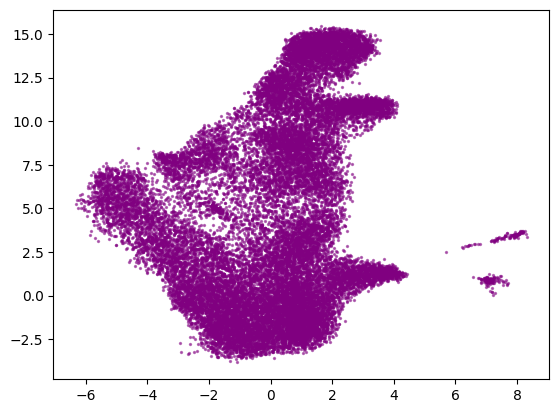

In [55]:
plt.scatter(\
    tea_anno_with_umap_ml["umap-x"].values, 
    tea_anno_with_umap_ml["umap-y"].values,
    s=2,
    alpha=0.5,
    color="purple")

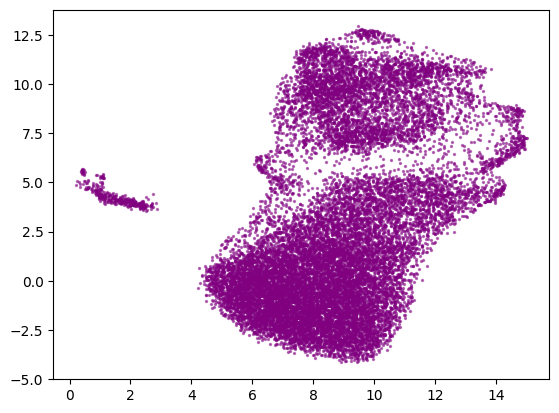

In [57]:
plt.scatter(\
    tea_anno_with_umap_hscp["umap-x"].values, 
    tea_anno_with_umap_hscp["umap-y"].values,
    s=2,
    alpha=0.5,
    color="purple")